# MlFlow Experiment Tracking Setup

In [2]:
import mlflow
mlflow.autolog()
mlflow.set_tracking_uri("http://localhost:8080")
mlflow.set_experiment("ResNet50_Freeze")
mlflow.set_tag("mlflow.runName", "version 1")
mlflow.set_experiment_tag

<function mlflow.tracking.fluent.set_experiment_tag(key: str, value: Any) -> None>

# Imports

In [3]:
import os
import cv2
import sys
from PIL import Image
from torchvision.transforms.functional import to_pil_image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
#Using Resnet50 for classification
import torchvision.models as models
import torch.nn as nn
from torchmetrics import Accuracy, Precision, Recall, F1Score
from pathlib import Path

MAIN_DIR = Path("__file__").resolve().parent.parent.parent
CLASSIFICATION_MAPPING_DIR = os.path.join(MAIN_DIR, "classification_mapping") 
if CLASSIFICATION_MAPPING_DIR not in sys.path:
    sys.path.insert(0, CLASSIFICATION_MAPPING_DIR)
from classification_mapping import CLASSIFICATION_MAPPING

DATA_DIR = os.path.join(MAIN_DIR, 'data')
TRANSLATED_DATA_DIR = os.path.join(MAIN_DIR, 'data_translated')

In [4]:
DEVICE = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cuda device


# Loading Dataset

In [5]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

In [6]:
# Function to transform images to 224x224 for ResNet with normalization based on
# original model image normalization settings
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [7]:
data, labels = [], []

# Reconverting the image to view in data_translated
mean = torch.tensor(mean).view(3, 1, 1)
std = torch.tensor(std).view(3, 1, 1)

for dir_ in os.listdir(DATA_DIR):
    path = os.path.join(DATA_DIR, dir_)
    translated_path = os.path.join(TRANSLATED_DATA_DIR, dir_)
    if not os.path.exists(translated_path): os.makedirs(translated_path)

    for img in os.listdir(path):
        # Load and transform the image
        image_path = os.path.join(path, img)
        image = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_pil = Image.fromarray(img_rgb)
        image_tensor = transform(img_pil)

        data.append(image_tensor)
        labels.append(dir_)

        # Convert back to PIL image, unnormalize, and save
        unnormalized = image_tensor * std + mean
        unnormalized = unnormalized.clamp(0, 1)
        
        image_pil = to_pil_image(unnormalized)
        image_translated_path = os.path.join(translated_path, img)
        image_pil.save(image_translated_path)

In [8]:
print(len(data))

178


In [9]:
class SignDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = torch.tensor([CLASSIFICATION_MAPPING[label] for label in labels], dtype=torch.long)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

    @property
    def classes(self):
        return self.data.classes

In [10]:
dataset = SignDataset(data, labels)
len(dataset)

178

In [11]:
train_dataset, test_dataset = random_split(dataset, [0.8, 0.2])
print(len(train_dataset))
print(len(test_dataset))

143
35


In [12]:
train_dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = 14, shuffle = True)

In [13]:
for data, label in train_dataloader:
    print(data.shape)
    print(label.shape)
    break

# Loading Pre-trained Model from Pytorch

In [15]:
model = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)
num_classes = 4 # Change output to 4 for desired classification task
model.fc = nn.Linear(model.fc.in_features, num_classes)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\Phuong Hoang Dinh/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100%|█████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:01<00:00, 58.9MB/s]


In [16]:
for param in model.parameters():
 param.requires_grad = False
# Unfreeze the last layer
for param in model.fc.parameters():
 param.requires_grad = True

In [17]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Model training

In [18]:
num_epochs = 400
train_losses, val_losses = [], []

model.to(DEVICE)

for epoch in range(num_epochs):
    model.train() #setting model mode .train or .eval
    running_loss = 0.0
    for image, labels in tqdm(train_dataloader, desc = "Training loop"):
        image, labels = image.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_dataloader.dataset)
    train_losses.append(train_loss)

    #Validation phase
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for image, labels in tqdm(test_dataloader, desc = "Validation loop"):
            image, labels = image.to(DEVICE), labels.to(DEVICE)
            outputs = model(image)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(test_dataloader.dataset)
    val_losses.append(val_loss)

    print("Epoch %d out of %s - Train loss: %s , Validation loss: %s" % (epoch + 1, num_epochs, train_loss, val_loss))

Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 out of 400 - Train loss: 1.3129931192719535 , Validation loss: 1.1128966093063355


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2 out of 400 - Train loss: 1.0736680948332455 , Validation loss: 0.9169968962669373


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3 out of 400 - Train loss: 0.8948644687620442 , Validation loss: 0.7476039886474609


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4 out of 400 - Train loss: 0.7501256023899893 , Validation loss: 0.6285627961158753


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5 out of 400 - Train loss: 0.6405226434214731 , Validation loss: 0.5395730257034301


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6 out of 400 - Train loss: 0.5468087785699395 , Validation loss: 0.4719302475452423


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7 out of 400 - Train loss: 0.4771545482485482 , Validation loss: 0.40526704788208007


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8 out of 400 - Train loss: 0.42184329200326726 , Validation loss: 0.35531129240989684


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9 out of 400 - Train loss: 0.37609755021802493 , Validation loss: 0.31618661284446714


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10 out of 400 - Train loss: 0.3481599922930257 , Validation loss: 0.28665800392627716


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11 out of 400 - Train loss: 0.2952471435739753 , Validation loss: 0.25967876315116883


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12 out of 400 - Train loss: 0.3027622046765317 , Validation loss: 0.23314499855041504


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13 out of 400 - Train loss: 0.2403855477825979 , Validation loss: 0.21774532794952392


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14 out of 400 - Train loss: 0.24124686938993048 , Validation loss: 0.19695477187633514


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15 out of 400 - Train loss: 0.22465030530865274 , Validation loss: 0.1812605381011963


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16 out of 400 - Train loss: 0.2031786548957396 , Validation loss: 0.16784783005714415


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17 out of 400 - Train loss: 0.1782644802934668 , Validation loss: 0.155354280769825


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18 out of 400 - Train loss: 0.17866638286060163 , Validation loss: 0.14201419651508332


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19 out of 400 - Train loss: 0.15363598355416502 , Validation loss: 0.13448198437690734


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20 out of 400 - Train loss: 0.151554201426131 , Validation loss: 0.12776528149843216


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21 out of 400 - Train loss: 0.1385736991180463 , Validation loss: 0.1178306594491005


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22 out of 400 - Train loss: 0.15054955576243026 , Validation loss: 0.11004587262868881


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23 out of 400 - Train loss: 0.12320033837570234 , Validation loss: 0.10358496159315109


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24 out of 400 - Train loss: 0.11574395871564244 , Validation loss: 0.09714481234550476


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25 out of 400 - Train loss: 0.11081932033045908 , Validation loss: 0.09118662327528


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26 out of 400 - Train loss: 0.10798641336098146 , Validation loss: 0.08642523288726807


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27 out of 400 - Train loss: 0.1161390971601679 , Validation loss: 0.08286321312189102


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28 out of 400 - Train loss: 0.09793772891666112 , Validation loss: 0.08020469546318054


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29 out of 400 - Train loss: 0.09802176560578721 , Validation loss: 0.07261607646942139


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30 out of 400 - Train loss: 0.09509066082118603 , Validation loss: 0.07451421022415161


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31 out of 400 - Train loss: 0.0869399659921614 , Validation loss: 0.06886182501912116


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 32 out of 400 - Train loss: 0.08673429849107614 , Validation loss: 0.06529090106487274


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 33 out of 400 - Train loss: 0.08554855918281534 , Validation loss: 0.06174760460853577


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 34 out of 400 - Train loss: 0.08312788228975253 , Validation loss: 0.056735144555568696


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 35 out of 400 - Train loss: 0.07261370733547746 , Validation loss: 0.05387307778000831


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 36 out of 400 - Train loss: 0.06873760728186436 , Validation loss: 0.05276833176612854


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 37 out of 400 - Train loss: 0.06601747828588057 , Validation loss: 0.051570338755846025


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 38 out of 400 - Train loss: 0.06971006112152271 , Validation loss: 0.04995203465223312


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 39 out of 400 - Train loss: 0.06121623047282187 , Validation loss: 0.04691391512751579


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 40 out of 400 - Train loss: 0.057781610261188464 , Validation loss: 0.046768516302108765


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 41 out of 400 - Train loss: 0.05906747750351938 , Validation loss: 0.04395595528185368


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 42 out of 400 - Train loss: 0.05710199441802635 , Validation loss: 0.043049967288970946


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 43 out of 400 - Train loss: 0.055445272015051894 , Validation loss: 0.03925175741314888


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 44 out of 400 - Train loss: 0.049481964848014745 , Validation loss: 0.03920113444328308


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 45 out of 400 - Train loss: 0.05202478655938352 , Validation loss: 0.03634579032659531


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 46 out of 400 - Train loss: 0.04541776973879739 , Validation loss: 0.03665169812738896


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 47 out of 400 - Train loss: 0.05476997662963492 , Validation loss: 0.036055779457092284


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 48 out of 400 - Train loss: 0.05061415151766177 , Validation loss: 0.03450837582349777


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 49 out of 400 - Train loss: 0.04839572138833196 , Validation loss: 0.033042972162365916


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 50 out of 400 - Train loss: 0.04733232065532984 , Validation loss: 0.03196665942668915


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 51 out of 400 - Train loss: 0.043480490198296105 , Validation loss: 0.030406439304351808


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 52 out of 400 - Train loss: 0.036262963176443334 , Validation loss: 0.02972891628742218


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 53 out of 400 - Train loss: 0.03981994084093008 , Validation loss: 0.029683168977499008


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 54 out of 400 - Train loss: 0.04464040378506264 , Validation loss: 0.028697768226265907


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 55 out of 400 - Train loss: 0.04220244824216607 , Validation loss: 0.027807462215423583


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 56 out of 400 - Train loss: 0.042979176794545035 , Validation loss: 0.027007247507572173


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 57 out of 400 - Train loss: 0.03389243496937698 , Validation loss: 0.025751885026693344


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 58 out of 400 - Train loss: 0.03640707598978214 , Validation loss: 0.024927570670843124


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 59 out of 400 - Train loss: 0.034698426032836516 , Validation loss: 0.02392505630850792


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 60 out of 400 - Train loss: 0.032025161377164754 , Validation loss: 0.023205390945076943


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 61 out of 400 - Train loss: 0.03789435829339403 , Validation loss: 0.02353488504886627


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 62 out of 400 - Train loss: 0.03258645576372575 , Validation loss: 0.022931324318051338


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 63 out of 400 - Train loss: 0.03220157568039519 , Validation loss: 0.021612712740898134


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 64 out of 400 - Train loss: 0.03860221660873863 , Validation loss: 0.022228221222758294


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 65 out of 400 - Train loss: 0.030809551226289086 , Validation loss: 0.021836599335074425


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 66 out of 400 - Train loss: 0.026694732896062764 , Validation loss: 0.020197078958153723


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 67 out of 400 - Train loss: 0.026971638077095652 , Validation loss: 0.019745640456676483


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 68 out of 400 - Train loss: 0.03053922892621394 , Validation loss: 0.019168388843536378


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 69 out of 400 - Train loss: 0.03679837179736475 , Validation loss: 0.018890279904007913


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 70 out of 400 - Train loss: 0.03714881050452758 , Validation loss: 0.018424014374613763


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 71 out of 400 - Train loss: 0.03561634536874428 , Validation loss: 0.018479715473949908


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 72 out of 400 - Train loss: 0.025435634103886197 , Validation loss: 0.0172489944845438


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 73 out of 400 - Train loss: 0.026432331818877983 , Validation loss: 0.01727244257926941


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 74 out of 400 - Train loss: 0.02362250605744592 , Validation loss: 0.01634014695882797


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 75 out of 400 - Train loss: 0.027564851169505817 , Validation loss: 0.016409729048609732


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 76 out of 400 - Train loss: 0.023976428036609394 , Validation loss: 0.01670221984386444


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 77 out of 400 - Train loss: 0.01940737786085418 , Validation loss: 0.015577046759426593


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 78 out of 400 - Train loss: 0.02450536137049118 , Validation loss: 0.015294793993234634


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 79 out of 400 - Train loss: 0.02438631821214483 , Validation loss: 0.015467052534222602


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 80 out of 400 - Train loss: 0.02246042847465933 , Validation loss: 0.01503600925207138


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 81 out of 400 - Train loss: 0.02244867890905798 , Validation loss: 0.015008941106498242


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 82 out of 400 - Train loss: 0.021450415128067637 , Validation loss: 0.015510784834623337


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 83 out of 400 - Train loss: 0.022672110163931097 , Validation loss: 0.014356974326074124


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 84 out of 400 - Train loss: 0.02020629533053784 , Validation loss: 0.01383642628788948


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 85 out of 400 - Train loss: 0.02081193197309301 , Validation loss: 0.013668155670166016


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 86 out of 400 - Train loss: 0.020786179731903453 , Validation loss: 0.014069403521716595


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 87 out of 400 - Train loss: 0.02006317675113678 , Validation loss: 0.013613475859165192


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 88 out of 400 - Train loss: 0.020966286823320926 , Validation loss: 0.01358821541070938


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 89 out of 400 - Train loss: 0.020304673215311566 , Validation loss: 0.01358061544597149


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 90 out of 400 - Train loss: 0.021916910503687482 , Validation loss: 0.013226084038615226


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 91 out of 400 - Train loss: 0.01858863506591722 , Validation loss: 0.012984346225857734


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 92 out of 400 - Train loss: 0.01845623402113325 , Validation loss: 0.012087206356227398


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 93 out of 400 - Train loss: 0.016771030246039455 , Validation loss: 0.012048777006566525


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 94 out of 400 - Train loss: 0.01867788592667392 , Validation loss: 0.011779635958373547


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 95 out of 400 - Train loss: 0.0176937769931019 , Validation loss: 0.011762623861432075


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 96 out of 400 - Train loss: 0.021644674994972316 , Validation loss: 0.011440390162169934


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 97 out of 400 - Train loss: 0.014537087149834364 , Validation loss: 0.010855474695563316


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 98 out of 400 - Train loss: 0.016563112732399715 , Validation loss: 0.010688749887049199


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 99 out of 400 - Train loss: 0.02098129823636473 , Validation loss: 0.010542406886816024


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 100 out of 400 - Train loss: 0.015280826142832134 , Validation loss: 0.01013501062989235


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 101 out of 400 - Train loss: 0.013536765355240094 , Validation loss: 0.009718792792409659


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 102 out of 400 - Train loss: 0.015659646685706095 , Validation loss: 0.009702151827514171


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 103 out of 400 - Train loss: 0.014940210251828259 , Validation loss: 0.009491626359522342


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 104 out of 400 - Train loss: 0.015251011095857352 , Validation loss: 0.0095973901450634


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 105 out of 400 - Train loss: 0.017362074675352387 , Validation loss: 0.009390487149357796


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 106 out of 400 - Train loss: 0.01256032097624259 , Validation loss: 0.008810108341276646


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 107 out of 400 - Train loss: 0.01378125496459811 , Validation loss: 0.009152907691895962


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 108 out of 400 - Train loss: 0.01549883040316989 , Validation loss: 0.00907770600169897


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 109 out of 400 - Train loss: 0.011872046114353652 , Validation loss: 0.009000869374722243


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 110 out of 400 - Train loss: 0.01454433798789978 , Validation loss: 0.008600768446922303


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 111 out of 400 - Train loss: 0.012189078699336962 , Validation loss: 0.00882069580256939


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 112 out of 400 - Train loss: 0.011004637319887623 , Validation loss: 0.008687692508101464


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 113 out of 400 - Train loss: 0.010833960141609894 , Validation loss: 0.00880296528339386


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 114 out of 400 - Train loss: 0.014683741029728664 , Validation loss: 0.008641650341451168


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 115 out of 400 - Train loss: 0.013896224559860284 , Validation loss: 0.008383050095289946


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 116 out of 400 - Train loss: 0.01418948027022769 , Validation loss: 0.008331585302948951


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 117 out of 400 - Train loss: 0.014914766634197047 , Validation loss: 0.007872523739933968


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 118 out of 400 - Train loss: 0.011972417406151804 , Validation loss: 0.00789289576932788


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 119 out of 400 - Train loss: 0.0128505216346363 , Validation loss: 0.007503806054592133


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 120 out of 400 - Train loss: 0.012240707351083166 , Validation loss: 0.006988392863422632


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 121 out of 400 - Train loss: 0.01189549606335297 , Validation loss: 0.006852526217699051


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 122 out of 400 - Train loss: 0.013403887870941269 , Validation loss: 0.007008413411676883


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 123 out of 400 - Train loss: 0.01220287625374419 , Validation loss: 0.006996763963252306


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 124 out of 400 - Train loss: 0.009762134968062466 , Validation loss: 0.0071210403926670555


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 125 out of 400 - Train loss: 0.011759256358059604 , Validation loss: 0.007194346655160189


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 126 out of 400 - Train loss: 0.01327404999331142 , Validation loss: 0.006856742221862078


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 127 out of 400 - Train loss: 0.014338418339075667 , Validation loss: 0.0068507703021168705


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 128 out of 400 - Train loss: 0.011052470915856656 , Validation loss: 0.006837412808090448


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 129 out of 400 - Train loss: 0.015198594294069858 , Validation loss: 0.006626408640295267


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 130 out of 400 - Train loss: 0.009940994694159272 , Validation loss: 0.006679454259574414


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 131 out of 400 - Train loss: 0.009579749087269386 , Validation loss: 0.006525015737861395


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 132 out of 400 - Train loss: 0.0097703200691704 , Validation loss: 0.006435929704457522


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 133 out of 400 - Train loss: 0.010126414719257461 , Validation loss: 0.006337358709424734


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 134 out of 400 - Train loss: 0.01130564452222224 , Validation loss: 0.006381912529468537


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 135 out of 400 - Train loss: 0.009662728767130481 , Validation loss: 0.006220831256359816


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 136 out of 400 - Train loss: 0.010194385152184562 , Validation loss: 0.006240368355065584


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 137 out of 400 - Train loss: 0.013243598340267546 , Validation loss: 0.0060364573262631895


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 138 out of 400 - Train loss: 0.012183040035156053 , Validation loss: 0.005986367259174586


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 139 out of 400 - Train loss: 0.014481032445105943 , Validation loss: 0.005990624986588955


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 140 out of 400 - Train loss: 0.007943382748308477 , Validation loss: 0.006066606938838958


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 141 out of 400 - Train loss: 0.007360327769112721 , Validation loss: 0.005707056820392608


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 142 out of 400 - Train loss: 0.01393932451525431 , Validation loss: 0.005718903243541717


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 143 out of 400 - Train loss: 0.010128583539319173 , Validation loss: 0.005615630839020014


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 144 out of 400 - Train loss: 0.009595644335900799 , Validation loss: 0.005544068105518818


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 145 out of 400 - Train loss: 0.00957723811603664 , Validation loss: 0.00553609998896718


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 146 out of 400 - Train loss: 0.009004316868239574 , Validation loss: 0.005367000866681337


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 147 out of 400 - Train loss: 0.0076167148987898664 , Validation loss: 0.005558391660451889


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 148 out of 400 - Train loss: 0.00768686207325271 , Validation loss: 0.005467728711664677


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 149 out of 400 - Train loss: 0.008497358205613125 , Validation loss: 0.005624641384929419


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 150 out of 400 - Train loss: 0.007571330880013744 , Validation loss: 0.005378157459199428


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 151 out of 400 - Train loss: 0.008438538550660851 , Validation loss: 0.005137014482170343


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 152 out of 400 - Train loss: 0.009556268509268091 , Validation loss: 0.0048217077273875475


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 153 out of 400 - Train loss: 0.007504309035753936 , Validation loss: 0.004910591803491115


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 154 out of 400 - Train loss: 0.0073590022040886825 , Validation loss: 0.004963246639817953


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 155 out of 400 - Train loss: 0.00996725165986278 , Validation loss: 0.004950257856398821


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 156 out of 400 - Train loss: 0.009956211939956366 , Validation loss: 0.004901157692074776


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 157 out of 400 - Train loss: 0.008004559240607398 , Validation loss: 0.004883573204278946


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 158 out of 400 - Train loss: 0.00704755610001556 , Validation loss: 0.004838156420737505


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 159 out of 400 - Train loss: 0.009545388202486413 , Validation loss: 0.004704333376139402


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 160 out of 400 - Train loss: 0.011940103191673086 , Validation loss: 0.004694846738129854


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 161 out of 400 - Train loss: 0.0072252224670367295 , Validation loss: 0.004441007133573293


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 162 out of 400 - Train loss: 0.010952719466321254 , Validation loss: 0.004574029007926583


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 163 out of 400 - Train loss: 0.008066924874869626 , Validation loss: 0.004421962425112724


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 164 out of 400 - Train loss: 0.009165897075965834 , Validation loss: 0.0045076239388436076


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 165 out of 400 - Train loss: 0.00945528383167942 , Validation loss: 0.004321295954287052


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 166 out of 400 - Train loss: 0.0063375549788555405 , Validation loss: 0.0042506969068199394


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 167 out of 400 - Train loss: 0.009265888754403992 , Validation loss: 0.0045327584259212015


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 168 out of 400 - Train loss: 0.0070291562738378395 , Validation loss: 0.004287842847406864


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 169 out of 400 - Train loss: 0.00818085369099392 , Validation loss: 0.00422224747017026


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 170 out of 400 - Train loss: 0.006440101923902383 , Validation loss: 0.004137687943875789


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 171 out of 400 - Train loss: 0.005435400574436683 , Validation loss: 0.0038857311476022003


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 172 out of 400 - Train loss: 0.009283834733487515 , Validation loss: 0.003978572227060795


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 173 out of 400 - Train loss: 0.006494016590622369 , Validation loss: 0.003893544338643551


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 174 out of 400 - Train loss: 0.008580936108496083 , Validation loss: 0.004009630717337132


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 175 out of 400 - Train loss: 0.006642685256103117 , Validation loss: 0.003916683560237289


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 176 out of 400 - Train loss: 0.00743345587692234 , Validation loss: 0.004018443357199431


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 177 out of 400 - Train loss: 0.007691185586573033 , Validation loss: 0.003692907700315118


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 178 out of 400 - Train loss: 0.011506806891620829 , Validation loss: 0.0037488506175577642


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 179 out of 400 - Train loss: 0.006607883808653007 , Validation loss: 0.0036230511497706173


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 180 out of 400 - Train loss: 0.00737771208743366 , Validation loss: 0.0034962207078933715


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 181 out of 400 - Train loss: 0.00691560927904054 , Validation loss: 0.0035030254628509285


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 182 out of 400 - Train loss: 0.00587277470177479 , Validation loss: 0.0036126937717199325


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 183 out of 400 - Train loss: 0.007004341769837931 , Validation loss: 0.0034553691279143096


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 184 out of 400 - Train loss: 0.004992284069067977 , Validation loss: 0.0033657554537057876


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 185 out of 400 - Train loss: 0.006657545423407233 , Validation loss: 0.0033341732807457445


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 186 out of 400 - Train loss: 0.005254789867720912 , Validation loss: 0.0034211276564747096


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 187 out of 400 - Train loss: 0.006319830016222563 , Validation loss: 0.003377252118662


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 188 out of 400 - Train loss: 0.005811420091417398 , Validation loss: 0.003412859048694372


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 189 out of 400 - Train loss: 0.008985930007327808 , Validation loss: 0.0035207884153351187


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 190 out of 400 - Train loss: 0.009085007681605521 , Validation loss: 0.0034238425083458423


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 191 out of 400 - Train loss: 0.006175696567286936 , Validation loss: 0.003239861223846674


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 192 out of 400 - Train loss: 0.007485712323798223 , Validation loss: 0.0033332115039229394


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 193 out of 400 - Train loss: 0.005806516594347659 , Validation loss: 0.0032516535371541976


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 194 out of 400 - Train loss: 0.006821536940386456 , Validation loss: 0.00312530267983675


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 195 out of 400 - Train loss: 0.007154344465960277 , Validation loss: 0.0030539579689502715


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 196 out of 400 - Train loss: 0.005041572265326977 , Validation loss: 0.0030373106710612774


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 197 out of 400 - Train loss: 0.004532323736864864 , Validation loss: 0.002927167993038893


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 198 out of 400 - Train loss: 0.006453410125850292 , Validation loss: 0.0029589999467134476


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 199 out of 400 - Train loss: 0.006041512960630856 , Validation loss: 0.003214063588529825


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 200 out of 400 - Train loss: 0.0059350493332643185 , Validation loss: 0.003018041420727968


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 201 out of 400 - Train loss: 0.007119113610785329 , Validation loss: 0.0033344289753586055


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 202 out of 400 - Train loss: 0.006712700386814187 , Validation loss: 0.003102902858518064


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 203 out of 400 - Train loss: 0.005209790657829033 , Validation loss: 0.0029224860016256573


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 204 out of 400 - Train loss: 0.007099135789308655 , Validation loss: 0.002977498108521104


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 205 out of 400 - Train loss: 0.006233637922265557 , Validation loss: 0.0029796567745506764


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 206 out of 400 - Train loss: 0.0050835965326830245 , Validation loss: 0.0028295999858528376


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 207 out of 400 - Train loss: 0.004496754714800568 , Validation loss: 0.0028391232248395682


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 208 out of 400 - Train loss: 0.005374300262231505 , Validation loss: 0.002840316528454423


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 209 out of 400 - Train loss: 0.004380351539408223 , Validation loss: 0.0030135422013700007


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 210 out of 400 - Train loss: 0.00714121259267578 , Validation loss: 0.0028938930016011


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 211 out of 400 - Train loss: 0.00618475680815035 , Validation loss: 0.002846824051812291


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 212 out of 400 - Train loss: 0.004096000062908684 , Validation loss: 0.002721321885474026


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 213 out of 400 - Train loss: 0.0061299663999777165 , Validation loss: 0.0026230944320559503


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 214 out of 400 - Train loss: 0.004900344814895914 , Validation loss: 0.002584599377587438


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 215 out of 400 - Train loss: 0.005098918913288063 , Validation loss: 0.0026350185740739106


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 216 out of 400 - Train loss: 0.005287546224975854 , Validation loss: 0.0026196502614766358


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 217 out of 400 - Train loss: 0.0036653608078492826 , Validation loss: 0.00257053948007524


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 218 out of 400 - Train loss: 0.004707970897133431 , Validation loss: 0.002646893495693803


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 219 out of 400 - Train loss: 0.005236729016799605 , Validation loss: 0.0026113579515367746


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 220 out of 400 - Train loss: 0.004661863790092508 , Validation loss: 0.0025450512766838074


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 221 out of 400 - Train loss: 0.005180413981250832 , Validation loss: 0.002575423661619425


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 222 out of 400 - Train loss: 0.004987111958685551 , Validation loss: 0.0024863131111487746


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 223 out of 400 - Train loss: 0.003891805448475179 , Validation loss: 0.0024377548368647696


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 224 out of 400 - Train loss: 0.003876765201056606 , Validation loss: 0.002392370253801346


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 225 out of 400 - Train loss: 0.003952990568588289 , Validation loss: 0.0023761328775435686


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 226 out of 400 - Train loss: 0.005878863699231925 , Validation loss: 0.0024268521461635827


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 227 out of 400 - Train loss: 0.004491512585180194 , Validation loss: 0.0024638835806399585


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 228 out of 400 - Train loss: 0.004441685372900762 , Validation loss: 0.002506916830316186


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 229 out of 400 - Train loss: 0.006260974290833044 , Validation loss: 0.002379975211806595


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 230 out of 400 - Train loss: 0.0039697423566844355 , Validation loss: 0.002261454821564257


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 231 out of 400 - Train loss: 0.006145116376031315 , Validation loss: 0.0023380177561193706


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 232 out of 400 - Train loss: 0.004613820139025704 , Validation loss: 0.002287717629224062


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 233 out of 400 - Train loss: 0.004546574944776766 , Validation loss: 0.0021877201506868005


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 234 out of 400 - Train loss: 0.006611749948410506 , Validation loss: 0.0022161263274028896


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 235 out of 400 - Train loss: 0.004885961960875586 , Validation loss: 0.002208067663013935


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 236 out of 400 - Train loss: 0.006005172858412346 , Validation loss: 0.0023426006082445383


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 237 out of 400 - Train loss: 0.004536113963368234 , Validation loss: 0.0023554507177323105


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 238 out of 400 - Train loss: 0.003967964404335852 , Validation loss: 0.002398242615163326


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 239 out of 400 - Train loss: 0.004102057641309299 , Validation loss: 0.0023530647391453384


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 240 out of 400 - Train loss: 0.004007235901911607 , Validation loss: 0.0022414606530219315


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 241 out of 400 - Train loss: 0.003713761257489076 , Validation loss: 0.002175570419058204


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 242 out of 400 - Train loss: 0.004552448231182741 , Validation loss: 0.002148056449368596


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 243 out of 400 - Train loss: 0.006817025770799497 , Validation loss: 0.0020183532033115625


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 244 out of 400 - Train loss: 0.0038995327051268534 , Validation loss: 0.0019803303526714443


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 245 out of 400 - Train loss: 0.00484690651705677 , Validation loss: 0.0020287252962589266


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 246 out of 400 - Train loss: 0.004310569621287705 , Validation loss: 0.0021197225200012327


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 247 out of 400 - Train loss: 0.004215647895516974 , Validation loss: 0.0021379687357693912


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 248 out of 400 - Train loss: 0.0032378185849134505 , Validation loss: 0.0021069578593596815


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 249 out of 400 - Train loss: 0.003547861646295766 , Validation loss: 0.002101903362199664


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 250 out of 400 - Train loss: 0.0037070493151046585 , Validation loss: 0.002031869674101472


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 251 out of 400 - Train loss: 0.004173726785216439 , Validation loss: 0.0018810771405696868


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 252 out of 400 - Train loss: 0.004038743538719215 , Validation loss: 0.0020164218731224537


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 253 out of 400 - Train loss: 0.0033409675279778713 , Validation loss: 0.001949470303952694


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 254 out of 400 - Train loss: 0.0033366307093018895 , Validation loss: 0.0018558098934590816


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 255 out of 400 - Train loss: 0.0028175527041547754 , Validation loss: 0.001773228426463902


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 256 out of 400 - Train loss: 0.0040464718679614955 , Validation loss: 0.0017435342306271195


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 257 out of 400 - Train loss: 0.005729471338557058 , Validation loss: 0.0018791784532368183


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 258 out of 400 - Train loss: 0.003005189433945029 , Validation loss: 0.00173718580044806


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 259 out of 400 - Train loss: 0.0033097078793504265 , Validation loss: 0.001771500939503312


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 260 out of 400 - Train loss: 0.003795537668583768 , Validation loss: 0.001768766320310533


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 261 out of 400 - Train loss: 0.003922238893639506 , Validation loss: 0.0017439909745007754


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 262 out of 400 - Train loss: 0.003441270294316699 , Validation loss: 0.0018600963521748781


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 263 out of 400 - Train loss: 0.0036105729555815794 , Validation loss: 0.001869452535174787


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 264 out of 400 - Train loss: 0.00349358810907167 , Validation loss: 0.0017802477115765214


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 265 out of 400 - Train loss: 0.0034193766219646074 , Validation loss: 0.0017570826690644025


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 266 out of 400 - Train loss: 0.0031577656359485025 , Validation loss: 0.0018069987650960683


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 267 out of 400 - Train loss: 0.002773250625835041 , Validation loss: 0.0017649791669100523


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 268 out of 400 - Train loss: 0.003312207046854362 , Validation loss: 0.0017236869083717466


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 269 out of 400 - Train loss: 0.0033122200644418094 , Validation loss: 0.0017388162668794394


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 270 out of 400 - Train loss: 0.003582241042422947 , Validation loss: 0.0016376626677811145


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 271 out of 400 - Train loss: 0.003171060171522451 , Validation loss: 0.0017073360737413167


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 272 out of 400 - Train loss: 0.004247628120977557 , Validation loss: 0.0016470049740746617


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 273 out of 400 - Train loss: 0.0026317210868000984 , Validation loss: 0.0016723161097615957


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 274 out of 400 - Train loss: 0.0033181227921518716 , Validation loss: 0.0017004557186737657


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 275 out of 400 - Train loss: 0.0035034294104140796 , Validation loss: 0.0015948143787682056


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 276 out of 400 - Train loss: 0.003687689719156603 , Validation loss: 0.0015148311387747527


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 277 out of 400 - Train loss: 0.003103271336033103 , Validation loss: 0.001538734813220799


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 278 out of 400 - Train loss: 0.0048079335057501045 , Validation loss: 0.001584121771156788


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 279 out of 400 - Train loss: 0.0041229802947700695 , Validation loss: 0.001445583312306553


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 280 out of 400 - Train loss: 0.0038392338797115207 , Validation loss: 0.0014269757783040404


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 281 out of 400 - Train loss: 0.0024416114915204183 , Validation loss: 0.0014445839915424585


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 282 out of 400 - Train loss: 0.002470067519108566 , Validation loss: 0.0014557575108483435


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 283 out of 400 - Train loss: 0.0036071643463513824 , Validation loss: 0.001551121915690601


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 284 out of 400 - Train loss: 0.0031440191708630725 , Validation loss: 0.0015037964330986142


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 285 out of 400 - Train loss: 0.0024085993658793108 , Validation loss: 0.0015198518754914402


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 286 out of 400 - Train loss: 0.0030735403383046053 , Validation loss: 0.0014726100722327828


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 287 out of 400 - Train loss: 0.002343761172208391 , Validation loss: 0.001449384563602507


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 288 out of 400 - Train loss: 0.0028993226640093863 , Validation loss: 0.001438929373398423


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 289 out of 400 - Train loss: 0.0028721050469183856 , Validation loss: 0.0013670113636180758


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 290 out of 400 - Train loss: 0.003964930822486791 , Validation loss: 0.0013773455750197173


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 291 out of 400 - Train loss: 0.0034033517363700975 , Validation loss: 0.001347871613688767


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 292 out of 400 - Train loss: 0.002584332736271821 , Validation loss: 0.0014067933661863208


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 293 out of 400 - Train loss: 0.0031350406535555807 , Validation loss: 0.001293631293810904


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 294 out of 400 - Train loss: 0.0029432707665006767 , Validation loss: 0.001344659156166017


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 295 out of 400 - Train loss: 0.0025015572724298813 , Validation loss: 0.0013514549704268576


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 296 out of 400 - Train loss: 0.0026666296886677823 , Validation loss: 0.0013453522697091103


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 297 out of 400 - Train loss: 0.0030244889491227236 , Validation loss: 0.001434420421719551


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 298 out of 400 - Train loss: 0.003610419261196021 , Validation loss: 0.0013658745214343072


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 299 out of 400 - Train loss: 0.0028772232321540962 , Validation loss: 0.0013002234743908047


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 300 out of 400 - Train loss: 0.00246808785170819 , Validation loss: 0.0013461744412779808


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 301 out of 400 - Train loss: 0.0025172146309292718 , Validation loss: 0.0012923608534038066


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 302 out of 400 - Train loss: 0.0036938388130805465 , Validation loss: 0.0013606386026367545


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 303 out of 400 - Train loss: 0.0025137624902169357 , Validation loss: 0.0013158677844330668


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 304 out of 400 - Train loss: 0.002692596149745952 , Validation loss: 0.001271399320103228


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 305 out of 400 - Train loss: 0.0022589837206171805 , Validation loss: 0.0012643380323424935


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 306 out of 400 - Train loss: 0.002666571159229687 , Validation loss: 0.001247285830322653


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 307 out of 400 - Train loss: 0.00288737059853385 , Validation loss: 0.0011912225745618343


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 308 out of 400 - Train loss: 0.002704554619372226 , Validation loss: 0.0012317533139139414


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 309 out of 400 - Train loss: 0.002130583132711354 , Validation loss: 0.001222279341891408


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 310 out of 400 - Train loss: 0.0026278348412008936 , Validation loss: 0.0011425661155954002


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 311 out of 400 - Train loss: 0.002591733716093422 , Validation loss: 0.0011514284065924584


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 312 out of 400 - Train loss: 0.0023566338055756655 , Validation loss: 0.0011358267860487104


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 313 out of 400 - Train loss: 0.0017703336655695953 , Validation loss: 0.0010862218448892235


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 314 out of 400 - Train loss: 0.0034786651978332005 , Validation loss: 0.001190148596651852


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 315 out of 400 - Train loss: 0.002712738582487689 , Validation loss: 0.0012220340897329152


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 316 out of 400 - Train loss: 0.0021300572258409825 , Validation loss: 0.001171724940650165


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 317 out of 400 - Train loss: 0.0019115943597692452 , Validation loss: 0.0012052132864482702


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 318 out of 400 - Train loss: 0.003027732365011248 , Validation loss: 0.0011488690273836256


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 319 out of 400 - Train loss: 0.0028814885168849083 , Validation loss: 0.0011927805608138442


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 320 out of 400 - Train loss: 0.0023336048300765205 , Validation loss: 0.0011814821627922356


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 321 out of 400 - Train loss: 0.0025519993250373374 , Validation loss: 0.0011373179964721202


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 322 out of 400 - Train loss: 0.002271684636152611 , Validation loss: 0.0011133550899103284


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 323 out of 400 - Train loss: 0.00212990274663303 , Validation loss: 0.0010603517876006663


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 324 out of 400 - Train loss: 0.002244584148571816 , Validation loss: 0.0010448064655065536


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 325 out of 400 - Train loss: 0.0034984218145019553 , Validation loss: 0.001138418517075479


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 326 out of 400 - Train loss: 0.003165451820228207 , Validation loss: 0.0011566468281671404


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 327 out of 400 - Train loss: 0.002088180146692844 , Validation loss: 0.0011559706996195017


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 328 out of 400 - Train loss: 0.0030725519669901453 , Validation loss: 0.001084068906493485


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 329 out of 400 - Train loss: 0.0022459952893216957 , Validation loss: 0.0010991674615070223


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 330 out of 400 - Train loss: 0.0026332176332309674 , Validation loss: 0.0011239540646784008


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 331 out of 400 - Train loss: 0.0036222941001479545 , Validation loss: 0.0011375978821888566


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 332 out of 400 - Train loss: 0.0020933780306426997 , Validation loss: 0.0011242689797654748


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 333 out of 400 - Train loss: 0.002028689460745186 , Validation loss: 0.0010856877197511494


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 334 out of 400 - Train loss: 0.0020315088619467583 , Validation loss: 0.0011366943828761578


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 335 out of 400 - Train loss: 0.002237619533925579 , Validation loss: 0.0010676746955141426


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 336 out of 400 - Train loss: 0.0021281473997854785 , Validation loss: 0.0010700771119445563


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 337 out of 400 - Train loss: 0.0020724305349370735 , Validation loss: 0.000994650786742568


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 338 out of 400 - Train loss: 0.0017017972540487065 , Validation loss: 0.00110595622099936


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 339 out of 400 - Train loss: 0.003541552158219091 , Validation loss: 0.0010152546688914298


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 340 out of 400 - Train loss: 0.0018704978989834867 , Validation loss: 0.0009995333733968438


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 341 out of 400 - Train loss: 0.0018568611023633667 , Validation loss: 0.0010413467651233077


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 342 out of 400 - Train loss: 0.0017759475524777944 , Validation loss: 0.0010160855716094374


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 343 out of 400 - Train loss: 0.002422007303057092 , Validation loss: 0.0010493954177945852


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 344 out of 400 - Train loss: 0.0025020063242592503 , Validation loss: 0.001006455102469772


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 345 out of 400 - Train loss: 0.002431524907019031 , Validation loss: 0.0009208577917888761


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 346 out of 400 - Train loss: 0.0021786834544952165 , Validation loss: 0.0009528451017104089


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 347 out of 400 - Train loss: 0.0027196787172154096 , Validation loss: 0.0009794465964660048


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 348 out of 400 - Train loss: 0.004394793328358217 , Validation loss: 0.0010286265518516303


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 349 out of 400 - Train loss: 0.0019722126968456117 , Validation loss: 0.0010452233487740158


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 350 out of 400 - Train loss: 0.0019848214729239096 , Validation loss: 0.0009634755435399712


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 351 out of 400 - Train loss: 0.0017140970403182038 , Validation loss: 0.0010128453141078353


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 352 out of 400 - Train loss: 0.0022834893839245433 , Validation loss: 0.0009989299811422824


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 353 out of 400 - Train loss: 0.002225199109989773 , Validation loss: 0.0010430916678160428


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 354 out of 400 - Train loss: 0.0024464913294650614 , Validation loss: 0.0009925568941980601


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 355 out of 400 - Train loss: 0.00415627380278422 , Validation loss: 0.0009372146567329764


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 356 out of 400 - Train loss: 0.0017290102956251483 , Validation loss: 0.0009410930098965764


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 357 out of 400 - Train loss: 0.0016798162702052447 , Validation loss: 0.000989016320090741


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 358 out of 400 - Train loss: 0.001750757305600335 , Validation loss: 0.0009714777581393719


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 359 out of 400 - Train loss: 0.0023947358026765704 , Validation loss: 0.0009071286651305855


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 360 out of 400 - Train loss: 0.0022854820793766655 , Validation loss: 0.0009084447170607746


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 361 out of 400 - Train loss: 0.002266274733740962 , Validation loss: 0.000952960702124983


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 362 out of 400 - Train loss: 0.002263049003825094 , Validation loss: 0.0008995164185762406


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 363 out of 400 - Train loss: 0.001638991010029999 , Validation loss: 0.0008747526677325368


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 364 out of 400 - Train loss: 0.0022816697261139247 , Validation loss: 0.0008365661487914622


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 365 out of 400 - Train loss: 0.00220619829036714 , Validation loss: 0.0008629335672594607


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 366 out of 400 - Train loss: 0.00214856462500822 , Validation loss: 0.0008735926705412567


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 367 out of 400 - Train loss: 0.0020474789590899196 , Validation loss: 0.0008580582099966705


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 368 out of 400 - Train loss: 0.0015583818024966153 , Validation loss: 0.0008189707295969129


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 369 out of 400 - Train loss: 0.0032509899583090555 , Validation loss: 0.0008193482295610011


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 370 out of 400 - Train loss: 0.0026549754266658528 , Validation loss: 0.0009070391184650362


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 371 out of 400 - Train loss: 0.0024439348483437234 , Validation loss: 0.0008207178208976984


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 372 out of 400 - Train loss: 0.001762239495292306 , Validation loss: 0.000794370612129569


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 373 out of 400 - Train loss: 0.0014539809630702385 , Validation loss: 0.0008024643640965224


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 374 out of 400 - Train loss: 0.001762721049233099 , Validation loss: 0.0008355342317372561


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 375 out of 400 - Train loss: 0.001703245664706056 , Validation loss: 0.0008021868532523512


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 376 out of 400 - Train loss: 0.0023612238001078367 , Validation loss: 0.0008518307586200535


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 377 out of 400 - Train loss: 0.0032744771288184637 , Validation loss: 0.0008661547675728798


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 378 out of 400 - Train loss: 0.002051911840026968 , Validation loss: 0.0008154119364917279


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 379 out of 400 - Train loss: 0.0017604140062512977 , Validation loss: 0.0008189240237697959


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 380 out of 400 - Train loss: 0.0018160131398923278 , Validation loss: 0.0008827895624563098


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 381 out of 400 - Train loss: 0.0017123730131163356 , Validation loss: 0.000855280295945704


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 382 out of 400 - Train loss: 0.0025341487332676232 , Validation loss: 0.0008260081405751408


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 383 out of 400 - Train loss: 0.001385659659595302 , Validation loss: 0.0008134092087857426


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 384 out of 400 - Train loss: 0.001939605680828014 , Validation loss: 0.0008333131205290556


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 385 out of 400 - Train loss: 0.0016985888974845745 , Validation loss: 0.0008275554981082677


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 386 out of 400 - Train loss: 0.0015696571339340356 , Validation loss: 0.000842104060575366


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 387 out of 400 - Train loss: 0.0016891895871860593 , Validation loss: 0.0007947570993565023


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 388 out of 400 - Train loss: 0.0014825445871925755 , Validation loss: 0.0007577040931209921


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 389 out of 400 - Train loss: 0.0022820785139383896 , Validation loss: 0.0008494853158481419


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 390 out of 400 - Train loss: 0.0017764464156764946 , Validation loss: 0.0008564403164200485


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 391 out of 400 - Train loss: 0.0017190417981172881 , Validation loss: 0.0007957322639413178


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 392 out of 400 - Train loss: 0.001352227572874909 , Validation loss: 0.000745803362224251


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 393 out of 400 - Train loss: 0.0013008833381483395 , Validation loss: 0.000750928174238652


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 394 out of 400 - Train loss: 0.001763518638071719 , Validation loss: 0.0007166228140704333


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 395 out of 400 - Train loss: 0.0017245597823449734 , Validation loss: 0.0007308432017453015


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 396 out of 400 - Train loss: 0.0013927477385765046 , Validation loss: 0.0007184766815043986


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 397 out of 400 - Train loss: 0.002331695995513308 , Validation loss: 0.0007226910267490894


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 398 out of 400 - Train loss: 0.0019177699336007739 , Validation loss: 0.0007365953526459635


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 399 out of 400 - Train loss: 0.0015596218323439695 , Validation loss: 0.0007430220604874194


Training loop:   0%|          | 0/6 [00:00<?, ?it/s]

Validation loop:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 400 out of 400 - Train loss: 0.0015705924721832356 , Validation loss: 0.0006898342166095972


# Visualize

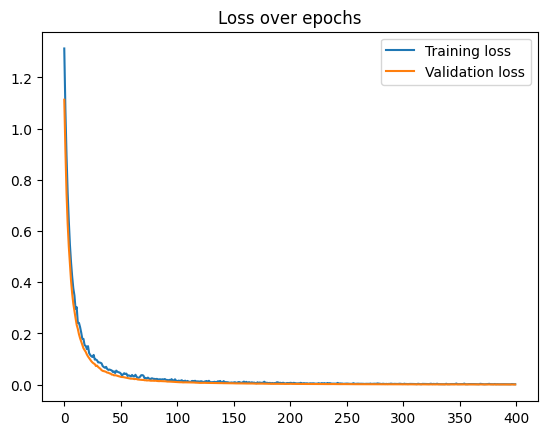

In [19]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.title("Loss over epochs")
plt.show()

# Load MlFlow Registerd Model

In [23]:
model_name = "ResNet50_Freeze"
model_version = "1"
model = mlflow.pytorch.load_model(f"models:/{model_name}/{model_version}")

RestException: RESOURCE_DOES_NOT_EXIST: Model Version (name=ResNet50_Freeze, version=2) not found

# Test Model with Seperated Test Data

In [18]:
def predict(model, image_path):
    image = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_pil = Image.fromarray(img_rgb)
    image_tensor = transform(img_pil).unsqueeze(0).to(DEVICE) #Already transformed into a tensor here

    model.eval()
    with torch.no_grad():
        predictions_log = model(image_tensor)
        predictions_prob = torch.exp(predictions_log)
        max_probability_predicted, max_probability_index = torch.max(predictions_prob, dim=1)
    return max_probability_index.item()

In [19]:
#TEST_FOLDER_DIR = os.path.join(os.path.dirname(MAIN_DIR), "test_data")
TEST_FOLDER_DIR = os.path.join(MAIN_DIR, "test_data")
predicted, ground_truth = [], []
for style in os.listdir(TEST_FOLDER_DIR):
    correct_result = CLASSIFICATION_MAPPING[style]
    style_path = os.path.join(TEST_FOLDER_DIR, style)
    for pic in os.listdir(style_path):
        predicted_result = predict(model, os.path.join(style_path, pic))
        predicted.append(predicted_result)
        ground_truth.append(correct_result)

In [20]:
predicted = torch.tensor(predicted)
ground_truth = torch.tensor(ground_truth)

accuracy = Accuracy(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro')
precision = Precision(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro')
recall = Recall(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro')
f1score = F1Score(task='multiclass', num_classes=len(CLASSIFICATION_MAPPING), average='macro')

accuracy.update(predicted, ground_truth)
precision.update(predicted, ground_truth)
recall.update(predicted, ground_truth)
f1score.update(predicted, ground_truth)

In [21]:
# Compute and print results
print("Accuracy:", accuracy.compute())
print("Precision:", precision.compute())
print("Recall:", recall.compute())
print("F1 Score:", f1score.compute())

Accuracy: tensor(0.8889)
Precision: tensor(0.8939)
Recall: tensor(0.8889)
F1 Score: tensor(0.8791)


# Logging with MlFlow

In [24]:
# Log parameters 
mlflow.log_param("optimizer", "Adam")
mlflow.log_param("learning_rate", 0.001)
mlflow.log_param("loss_function", "CrossEntropyLoss")
mlflow.log_param("epoch", 400)
mlflow.log_param("traing_batch_size", 32)
mlflow.log_param("validation_batch_size", 14)

14

In [25]:
# Log result
mlflow.log_metric("train_loss", train_loss)
mlflow.log_metric("validation_loss", val_loss)
mlflow.log_metric("test_accuracy", accuracy.compute())
mlflow.log_metric("test_precision", precision.compute())
mlflow.log_metric("test_recall", recall.compute())
mlflow.log_metric("test_f1", f1score.compute())

In [26]:
# Log dataset
mlflow.log_artifacts(DATA_DIR, artifact_path="dataset")
mlflow.log_artifacts(TEST_FOLDER_DIR, artifact_path="test_dataset")

In [27]:
# Log model
mlflow.pytorch.log_model(artifact_path="ResNet50_Freeze", pytorch_model=model, registered_model_name="ResNet50_Freeze")

2025/06/11 16:27:50 WARNING mlflow.utils.requirements_utils: Found torch version (2.7.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.7.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/11 16:28:03 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.22.0+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torchvision==0.22.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/06/11 16:28:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Successfully registered model 'ResNet5